In [ ]:
import os
import re
import pandas as pd
import numpy as np
import heapq
import matplotlib.pyplot as plt
import rasterio
from rasterio.crs import CRS
from rasterio.features import rasterize
from rasterio.warp import transform as warp_transform
from rasterio.warp import calculate_default_transform, reproject, Resampling, transform_geom
from rasterio.enums import Resampling
from rasterio.transform import xy, rowcol
from shapely.geometry import mapping, LineString

from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

# READ-ME


In [ ]:
'''
DEPENDENCIES: numpy, pandas, rasterio, shapely, heapq, matplotlib, shapely, tqdm

DATA INPUT:
- NORTHERN HEMISPHERE TIF FILE
- ICE CONCENTRATION DATA FOR 2024-09-20 (ARBITRARY DAY WAS CHOSEN FOR A CHECKER MAP)
- A CSV FILE CONTAINING PREDICTED CONCENTRATION OF ICE PER PIXEL IN THE ARCTIC ('created_data/predicted_concentration.csv')
    - BACKUP FILE HAS BEEN PROVIDED ('created_data/backup_data/predicted_concentration_backup.csv')

THE NORTHERN HEMISPHERE TIF FILE HAS BEEN POVIDED BUT CAN ALSO BE ACCESSED HERE: https://www.naturalearthdata.com/downloads/
    - MEDIUM SCALE DATA, 1:50 RASTER

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

EXPLANATION:
- CREATES A BASE MAP WITH ICE TO MANUALLY CHECK 
- CREATES A BASE MAP (NO ICE)
- USES BASE MAP TO CREATE MAPS WITH FORCASTED ICE EMBEDDED IN THEM
- RUNS FROM 2025-2050 CREATING FORCASTED ICE MAPS FOR EACH DAY 

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

FOR QUESTION OR ISSUES CONTACT: 
- Ioannis Thomopoulos       -->  ioannis.thomopoulos@studbocconi.it
- Jacopo D'Angelo           -->  jacopo.dangelo@studbocconi.it
- Max Rienth                -->  maximilian.rienth@studbocconi.it
- Luca Milani               -->  luca.milani2@studbocconi.it

'''

''

# CREATING A SINGLE 'BASE + ICE' MAP


In [ ]:
base_path = 'created_data/northern_hemisphere_ne.tif'
ice_path  = 'original_data/ice_tifs_historic/2024_N_20240920_concentration_v3.0.tif'
out_path  = 'created_data/presentation.tif'

CRS_LONLAT = CRS.from_epsg(4326)
CRS_OUT    = CRS.from_epsg(3411)

###############################
with rasterio.open(base_path) as src_base:
    base = src_base.read(1).astype(np.float32)           # 0=water, 1=land
    base_transform = src_base.transform
    base_width, base_height = src_base.width, src_base.height
    # we know its CRS is missing: assume WGS84 lat/lon
    base_crs = CRS_LONLAT
    base_bounds = src_base.bounds

###############################
ice_on_base = np.zeros_like(base)
with rasterio.open(ice_path) as src_ice:
    reproject(
        source=rasterio.band(src_ice, 1),
        destination=ice_on_base,
        src_transform=src_ice.transform,
        src_crs=src_ice.crs,
        dst_transform=base_transform,
        dst_crs=base_crs,
        resampling=Resampling.nearest
    )

print("Ice on base grid:", ice_on_base.min(), "/", ice_on_base.max())
###############################
merged_latlon = np.where(
    (ice_on_base > 0) & (ice_on_base <= 1000),
    ice_on_base,
    np.where(base == 1, 3000, 0)
)

print("Merged in lat/lon:", merged_latlon.min(), "/", merged_latlon.max())

###############################
with rasterio.open(ice_path) as src_ice:
    ice_res = (abs(src_ice.transform.a), abs(src_ice.transform.e))

#    Compute the target grid in 3411:
transform_out, w_out, h_out = calculate_default_transform(
    CRS_LONLAT, CRS_OUT,
    base_width, base_height,
    *base_bounds,
    resolution=ice_res
)

profile = {
    'driver': 'GTiff',
    'dtype': 'float32',
    'count': 1,
    'crs': CRS_OUT,
    'transform': transform_out,
    'width': w_out,
    'height': h_out,
    'nodata': 0
}

merged_out = np.zeros((h_out, w_out), dtype=np.float32)
reproject(
    source=merged_latlon,
    destination=merged_out,
    src_transform=base_transform,
    src_crs=CRS_LONLAT,
    dst_transform=transform_out,
    dst_crs=CRS_OUT,
    resampling=Resampling.nearest
)

with rasterio.open(out_path, 'w', **profile) as dst:
    dst.write(merged_out, 1)

print("Wrote merged to:", out_path)

# CHECK TO MAKE SURE IT WORKS


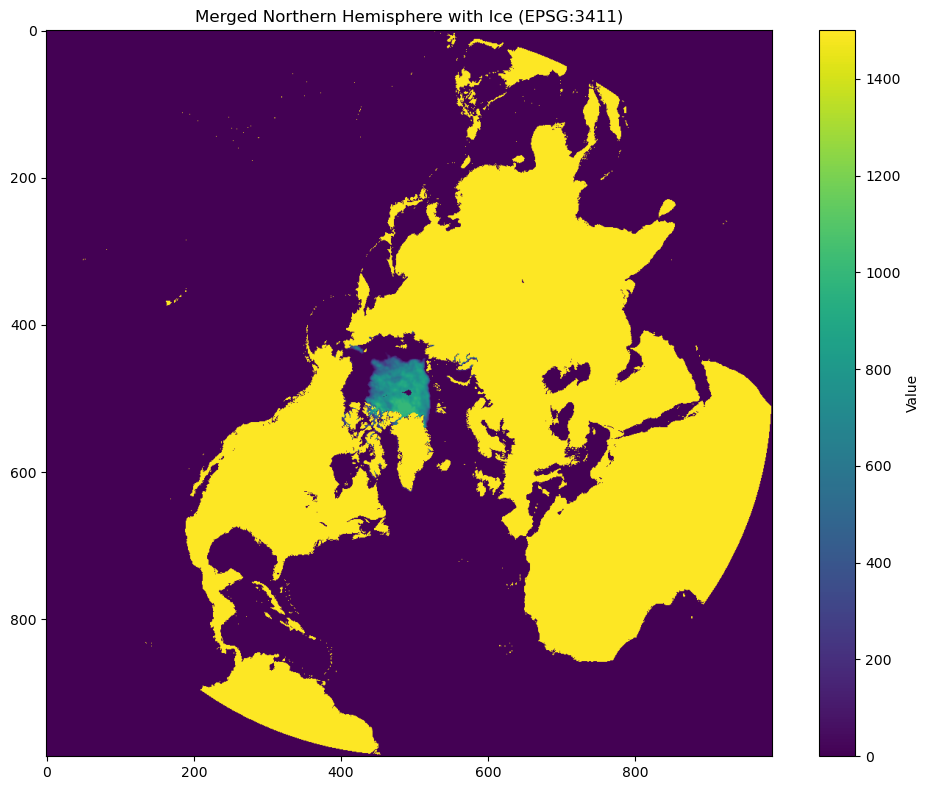

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(merged_out, origin='upper', vmin=0, vmax=1500)
plt.title('Merged Northern Hemisphere with Ice (EPSG:3411)')
plt.colorbar(label='Value')
plt.tight_layout()
plt.show()

# CREATING ICE FREE MAP


In [ ]:
# Paths
input_tif    = 'created_data/presentation.tif'
base_output  = 'created_data/base_no_ice.tif'

with rasterio.open(input_tif) as src:
    data    = src.read(1).astype(np.float32)
    profile = src.profile.copy()

ice_mask = (data > 0) & (data < 1001)
data[ice_mask] = 0

with rasterio.open(base_output, 'w', **profile) as dst:
    dst.write(data, 1)

print(f'Wrote ice-free base file to: {base_output}')

Wrote ice-free base file to: created_data/base_no_ice.tif


# APPLYING FORCASTED ICE TO MAPS (2025-2050)


#### ALSO ADDING CANALS


In [ ]:
BASE_INPUT    = 'created_data/base_no_ice.tif'
ICE_PATH      = 'original_data/ice_tifs_historic/2024_N_20240920_concentration_v3.0.tif'
CSV_PATH      = 'created_data/predicted_concentration.csv'
# CSV_PATH      = 'created_data/backup_data/predicted_concentration_backup.csv'
OUT_DIR       = 'created_data/future_ice_maps'
os.makedirs(OUT_DIR, exist_ok=True)

with rasterio.open(BASE_INPUT) as src:
    base_template   = src.read(1)
    profile         = src.profile.copy()
    transform_base  = src.transform
    crs_base        = src.crs
    height, width   = src.height, src.width

with rasterio.open(ICE_PATH) as src_ice:
    transform_ice = src_ice.transform

suez = LineString([(32.302856,31.371905),(32.349123,30.535917),(32.541629,29.881941)])
panama = LineString([(-79.926716,9.377336),(-79.730600,9.119844),(-79.545007,8.911799)])
suez_p = transform_geom("EPSG:4326", crs_base.to_string(), mapping(suez))
panama_p = transform_geom("EPSG:4326", crs_base.to_string(), mapping(panama))
canal_mask = rasterize(
    [(suez_p,1),(panama_p,1)],
    out_shape=(height,width),
    transform=transform_base,
    all_touched=True,
    dtype='uint8'
)

df = pd.read_csv(CSV_PATH, parse_dates=['date'])
dates = sorted(df['date'].unique())

def apply_day(df_day):
    arr = base_template.copy()
    for _, row in df_day.iterrows():
        x, y = xy(transform_ice, int(row['row']), int(row['col']), offset='center')
        try:
            r, c = rowcol(transform_base, x, y)
        except ValueError:
            continue
        if 0 <= r < height and 0 <= c < width:
            arr[r, c] = row['predicted_concentration']
    arr[canal_mask == 1] = 0
    out_name = f'ice_{df_day.name.strftime("%Y%m%d")}.tif'
    out_path = os.path.join(OUT_DIR, out_name)
    with rasterio.open(out_path, 'w', **profile) as dst:
        dst.write(arr, 1)


# MAIN CODE EXECUTER


#### THIS MIGHT TAKE SOME TIME TO RUN


In [ ]:
if __name__ == '__main__':
    # sample map
    sample_date = dates[0]
    sample_df = df[df['date'] == sample_date].set_index('date')
    sample_df.name = sample_date
    apply_day(sample_df)

    # parallel processing
    def task(d):
        subset = df[df['date'] == d].set_index('date')
        subset.name = d
        apply_day(subset)

    with ThreadPoolExecutor(max_workers=12) as executor:
        list(tqdm(executor.map(task, dates), total=len(dates), desc='Writing daily maps'))

Writing daily maps:   0%|          | 12/9490 [00:59<12:57:32,  4.92s/it]
